# Importações

In [ ]:
from PIL import Image
from IPython.display import Video
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow as show
import numpy as np
import urllib.request
import math
import dlib

urllib.request.urlretrieve("https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat", './shape_predictor_68_face_landmarks.dat')

('./shape_predictor_68_face_landmarks.dat',
 <http.client.HTTPMessage at 0x7f942b60a710>)

In [ ]:
urllib.request.urlretrieve("https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Emotion%20Detection/shape_predictor_68_face_landmarks.dat", './shape_predictor_68_face_landmarks.dat')
frontalface_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

LEBRON = cv2.imread("/content/LEBRON.jpg")
LEGOAT = cv2.imread("/content/LEGOAT.webp")

# Funções

In [ ]:
def get_landmarks(image_source):

    if image_source.startswith('http'):
        url_response = urllib.request.urlopen(image_source)
        img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
        image = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    else:
        image = cv2.imread(image_source)

    if image is None:
        raise ValueError("Imagem não pôde ser carregada. Verifique a URL ou o caminho do arquivo.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = frontalface_detector(gray, 1)

    if len(faces) == 0:
        raise ValueError("Nenhum rosto detectado na imagem.")

    landmarks = [(p.x, p.y) for p in landmark_predictor(gray, faces[0]).parts()]
    return image, landmarks

In [ ]:
def image_landmarks(image, landmarks, title='Imagem com Landmarks'):

    h, w = image.shape[:2]
    base_radius = max(1, min(h, w) // 200)
    thickness = -1

    image_copy = image.copy()
    for (x, y) in landmarks:
        cv2.circle(image_copy, (x, y), base_radius, (0, 0, 255), thickness)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(title)
    plt.show()

In [ ]:
def alinhar_e_cortar_rosto(image, landmarks, tamanho_crop=(750,750), margem=230):

    h, w = image.shape[:2]

    olho_esq = np.mean(landmarks[36:42], axis=0)
    olho_dir = np.mean(landmarks[42:48], axis=0)

    dx = olho_dir[0] - olho_esq[0]
    dy = olho_dir[1] - olho_esq[1]
    angulo = np.degrees(np.arctan2(dy, dx))

    # Centro entre os olhos
    cx, cy = (olho_esq[0] + olho_dir[0]) / 2, (olho_esq[1] + olho_dir[1]) / 2

    # Matriz para rotacionar a imagem e alinhar os olhos horizontalmente
    M = cv2.getRotationMatrix2D((cx, cy), angulo, 1.0)
    img_rotacionada = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)

    landmarks_rotacionadas = []
    for (x, y) in landmarks:
        vetor = np.array([x, y, 1])
        x_rot, y_rot = M.dot(vetor)
        landmarks_rotacionadas.append((int(x_rot), int(y_rot)))

    xs = [p[0] for p in landmarks_rotacionadas]
    ys = [p[1] for p in landmarks_rotacionadas]

    min_x = max(min(xs) - margem, 0)
    max_x = min(max(xs) + margem, w)
    min_y = max(min(ys) - margem, 0)
    max_y = min(max(ys) + margem, h)

    rosto_crop = img_rotacionada[int(min_y):int(max_y), int(min_x):int(max_x)]
    landmarks_crop = [(x - min_x, y - min_y) for (x, y) in landmarks_rotacionadas]
    rosto_final = cv2.resize(rosto_crop, tamanho_crop)

    escala_x = tamanho_crop[0] / (max_x - min_x)
    escala_y = tamanho_crop[1] / (max_y - min_y)
    landmarks_final = [(int(x * escala_x), int(y * escala_y)) for (x, y) in landmarks_crop]

    return rosto_final, landmarks_final

# Resultados

Digite URL ou caminho da imagem: /content/cr7_perfil.jpg


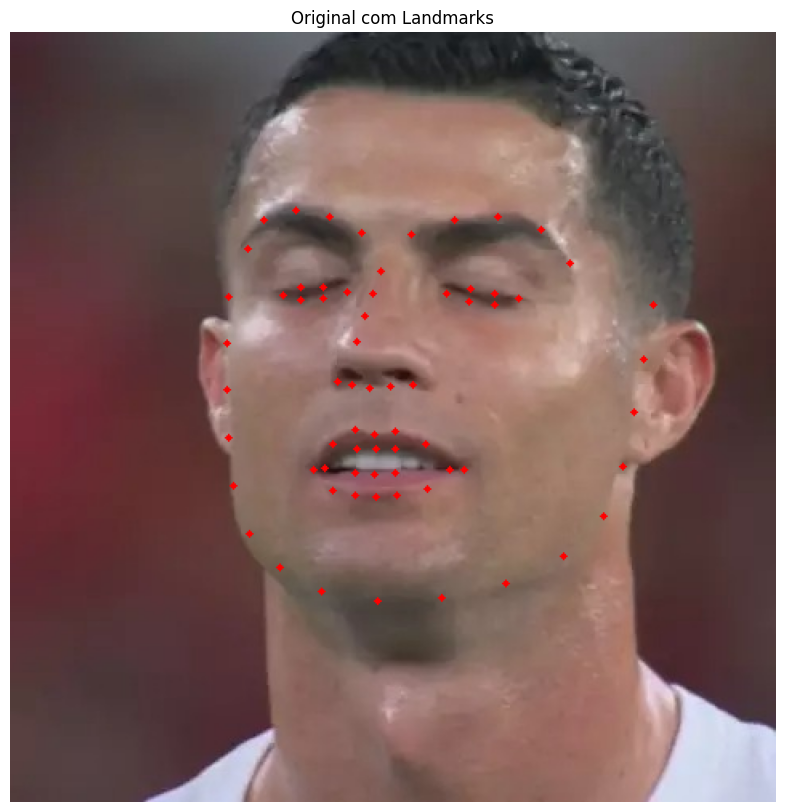

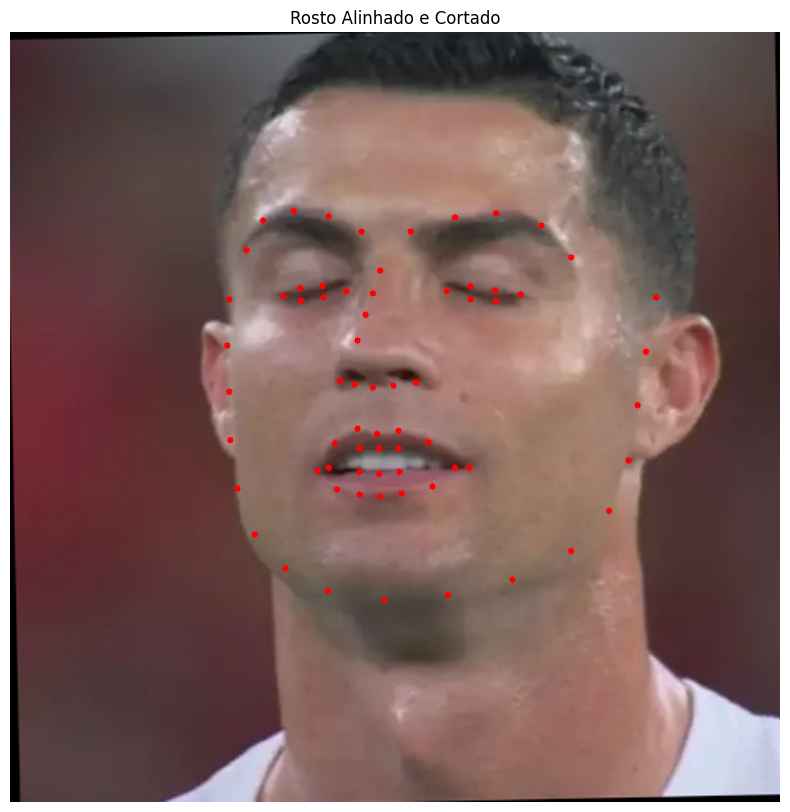

In [ ]:
caminho_ou_url = input("Digite URL ou caminho da imagem: ")
image, landmarks = get_landmarks(caminho_ou_url)
image_landmarks(image, landmarks, title='Original com Landmarks')

rosto_alinhado, landmarks_alinhadas = alinhar_e_cortar_rosto(image, landmarks)
image_landmarks(rosto_alinhado, landmarks_alinhadas, title='Rosto Alinhado e Cortado')

Caminho ou URL da imagem frontal: /content/lebron_frontal.jpg
Caminho ou URL da imagem perfil: /content/lebron_perfil.webp


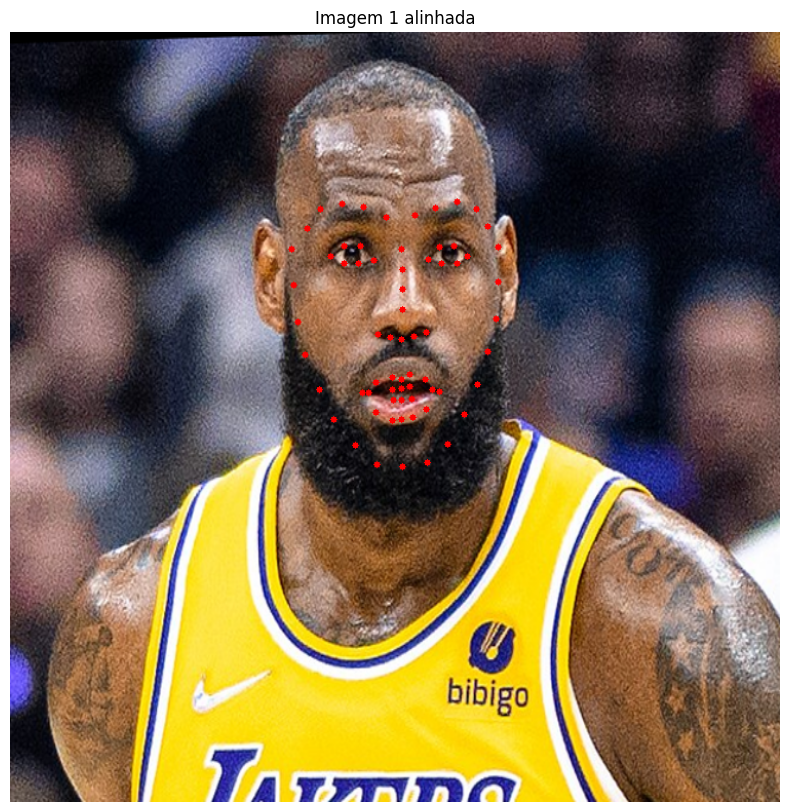

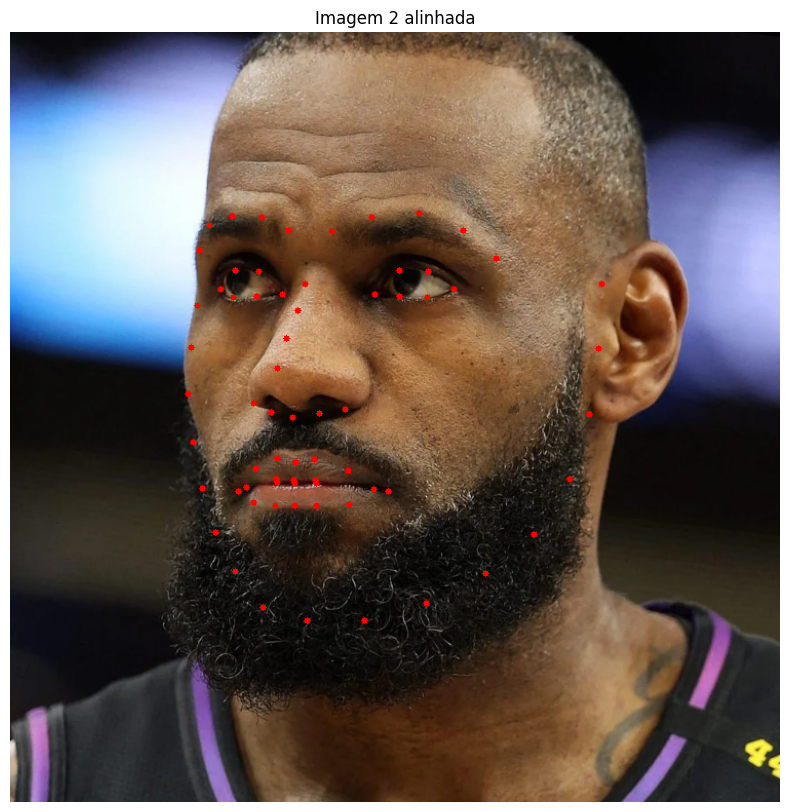

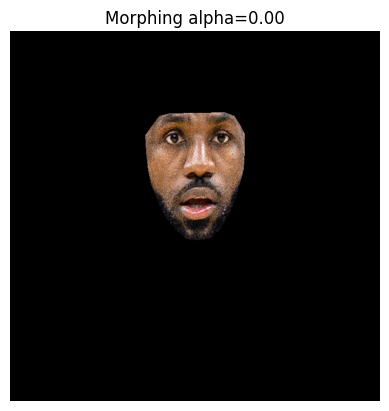

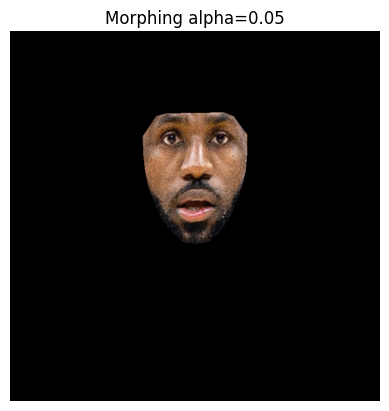

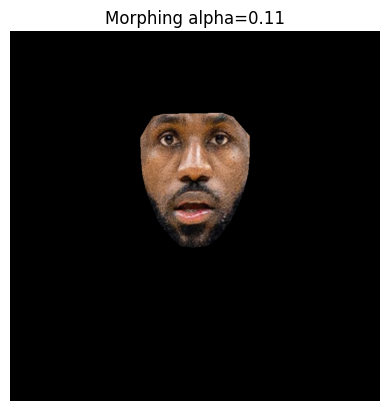

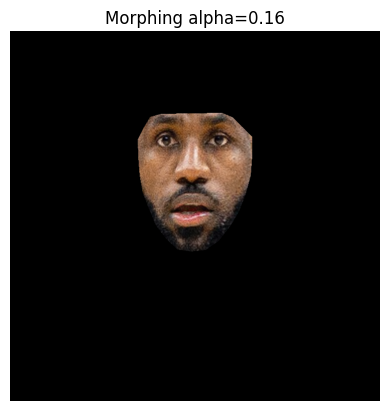

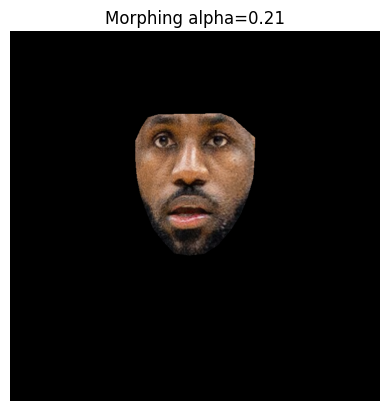

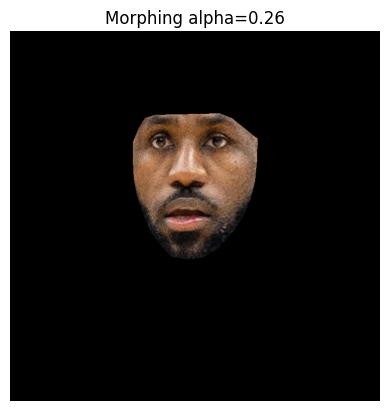

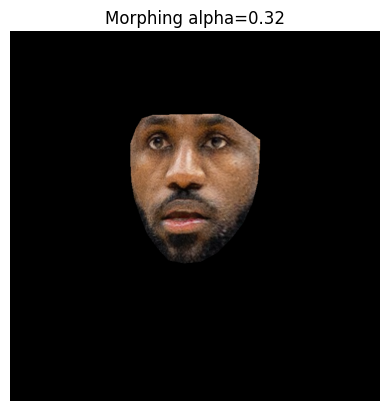

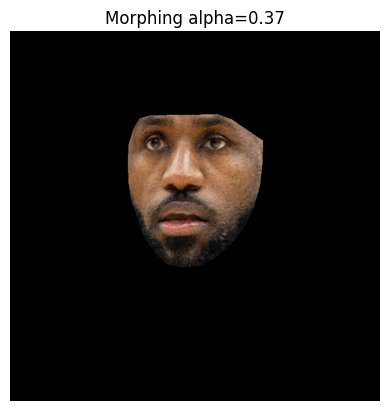

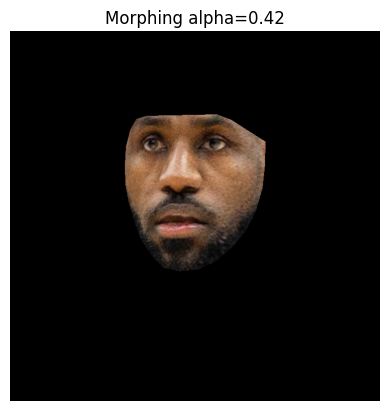

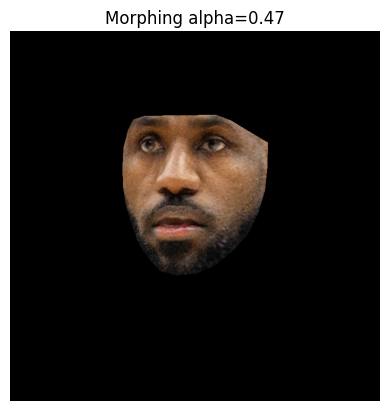

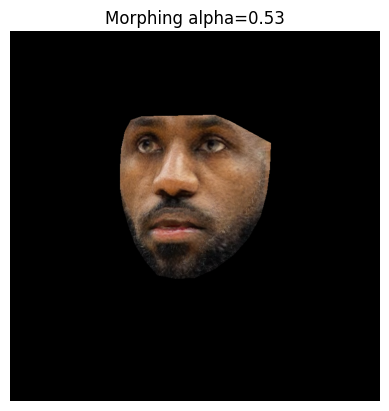

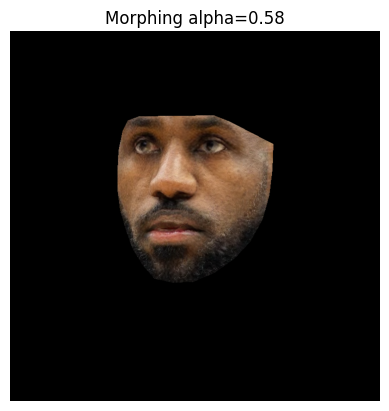

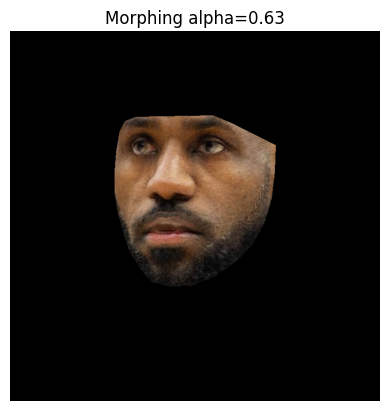

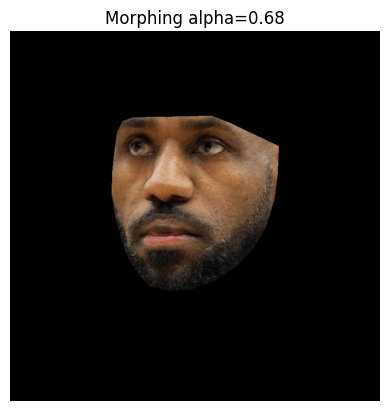

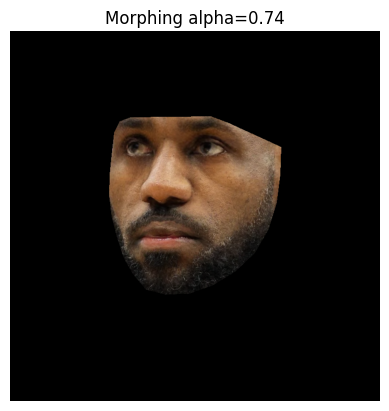

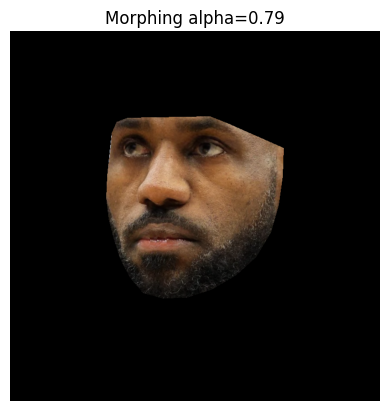

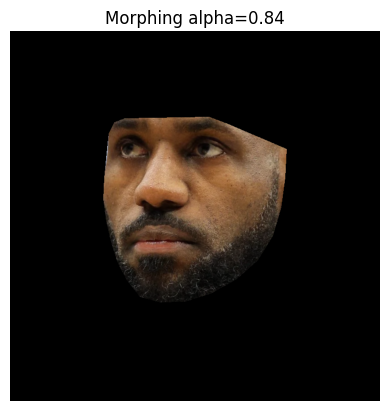

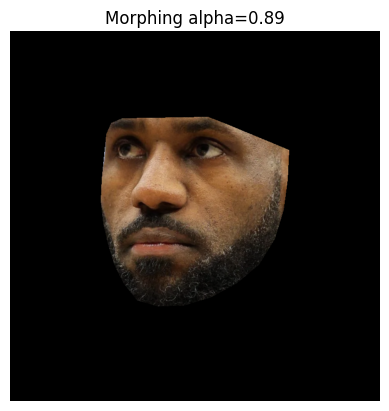

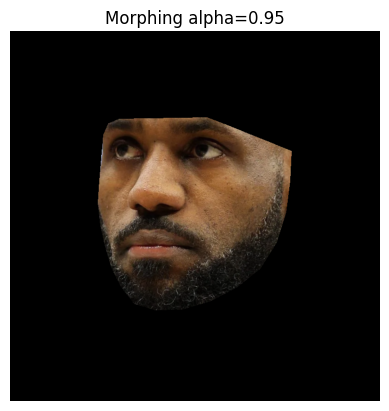

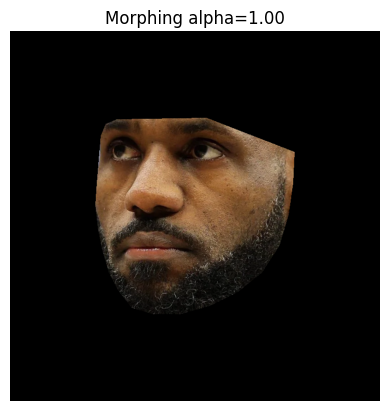

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

def ler_imagem_e_landmarks(caminho):
    img, lm = get_landmarks(caminho)
    rosto, lm_alinhadas = alinhar_e_cortar_rosto(img, lm)
    return rosto, lm_alinhadas

def calcular_pontos_intermediarios(lm1, lm2, alpha):
    lm1 = np.array(lm1, dtype=np.float32)
    lm2 = np.array(lm2, dtype=np.float32)
    return (1 - alpha) * lm1 + alpha * lm2

def aplicar_warp_triangle(img, tri1, tri, tamanho):
    # calcula matriz afim que transforma tri1 em tri e aplica warp
    tri1 = np.array(tri1, dtype=np.float32)
    tri = np.array(tri, dtype=np.float32)

    # bounding rects
    r1 = cv2.boundingRect(tri1)
    r = cv2.boundingRect(tri)

    # Offset dos triângulos para dentro do bounding rect
    tri1_offset = [(pt[0] - r1[0], pt[1] - r1[1]) for pt in tri1]
    tri_offset = [(pt[0] - r[0], pt[1] - r[1]) for pt in tri]

    img1_rect = img[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]

    # Matriz afim
    M = cv2.getAffineTransform(np.float32(tri1_offset), np.float32(tri_offset))

    warped_rect = cv2.warpAffine(img1_rect, M, (r[2], r[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    # Máscara para triângulo
    mask = np.zeros((r[3], r[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri_offset), (1.0, 1.0, 1.0), 16, 0)

    return warped_rect, mask, r

def morphing_faces(img1, img2, lm1, lm2, alpha):
    # Imagens devem ser do mesmo tamanho
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)

    pontos_inter = calcular_pontos_intermediarios(lm1, lm2, alpha)

    # Triangulação Delaunay na imagem intermediária
    tri = Delaunay(pontos_inter)

    img_morph = np.zeros(img1.shape, dtype=img1.dtype)

    for t in tri.simplices:
        tri1 = [lm1[t[0]], lm1[t[1]], lm1[t[2]]]
        tri2 = [lm2[t[0]], lm2[t[1]], lm2[t[2]]]
        tri_inter = [pontos_inter[t[0]], pontos_inter[t[1]], pontos_inter[t[2]]]

        warped1, mask1, r = aplicar_warp_triangle(img1, tri1, tri_inter, img1.shape)
        warped2, mask2, _ = aplicar_warp_triangle(img2, tri2, tri_inter, img2.shape)

        # Mesclar as duas imagens warped
        img_morph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img_morph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * (1 - mask1) + \
            (warped1 * (1 - alpha) + warped2 * alpha) * mask1

    return np.clip(img_morph, 0, 255).astype(np.uint8)

# --- Exemplo de uso ---

# Carregue as imagens e landmarks já alinhados e recortados
caminho1 = input("Caminho ou URL da imagem frontal: ")
caminho2 = input("Caminho ou URL da imagem perfil: ")
img1, lm1 = ler_imagem_e_landmarks(caminho1)
image_landmarks(img1, lm1, "Imagem 1 alinhada")
img2, lm2 = ler_imagem_e_landmarks(caminho2)
image_landmarks(img2, lm2, "Imagem 2 alinhada")

# Criar frames de morphing variando alpha de 0 a 1
for alpha in np.linspace(0, 1, 20):
    img_morph = morphing_faces(img1, img2, lm1, lm2, alpha)
    plt.imshow(cv2.cvtColor(img_morph, cv2.COLOR_BGR2RGB))
    plt.title(f'Morphing alpha={alpha:.2f}')
    plt.axis('off')
    plt.show()


Caminho ou URL da imagem FRONTAL: /content/lebron_frontal.jpg
Caminho ou URL da imagem PERFIL: /content/lebron_perfil.webp


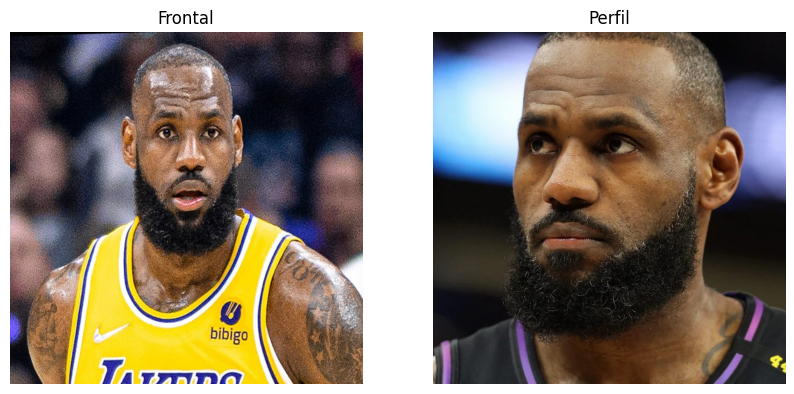

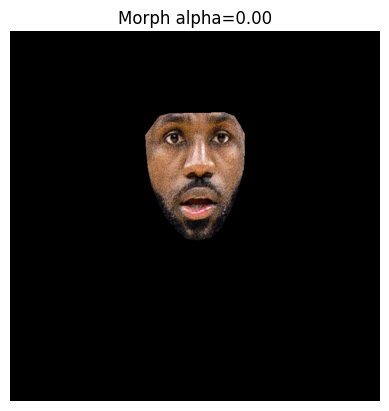

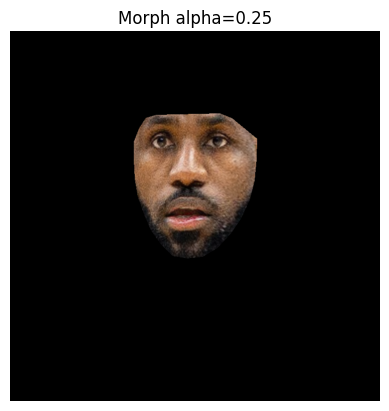

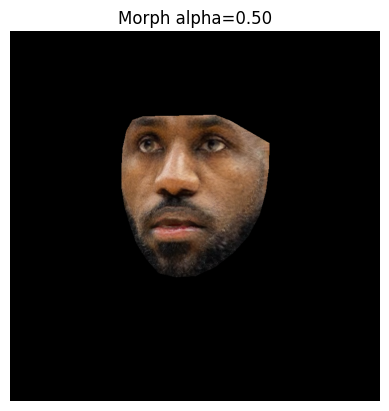

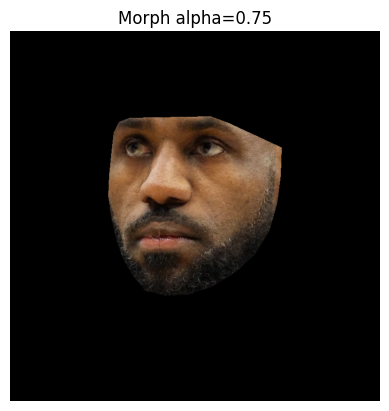

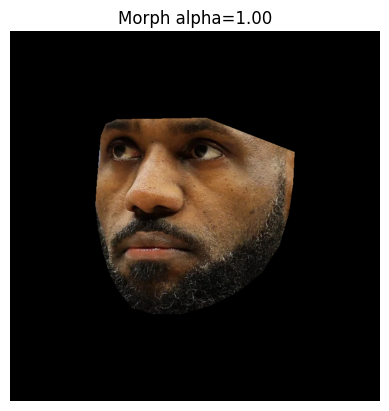

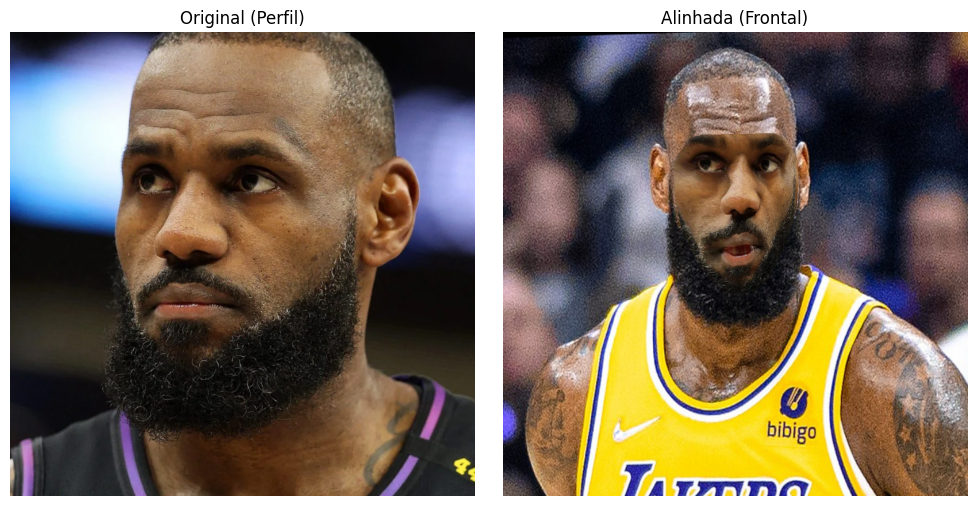

True

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Função do usuário: leitura e alinhamento dos landmarks
def ler_imagem_e_landmarks(caminho):
    img, lm = get_landmarks(caminho)
    rosto, lm_alinhadas = alinhar_e_cortar_rosto(img, lm)
    return rosto, lm_alinhadas

def calcular_pontos_intermediarios(lm1, lm2, alpha):
    lm1 = np.array(lm1, dtype=np.float32)
    lm2 = np.array(lm2, dtype=np.float32)
    return (1 - alpha) * lm1 + alpha * lm2

def aplicar_warp_triangle(img, tri1, tri2, tamanho):
    tri1 = np.array(tri1, dtype=np.float32)
    tri2 = np.array(tri2, dtype=np.float32)

    r1 = cv2.boundingRect(tri1)
    r2 = cv2.boundingRect(tri2)

    tri1_offset = [(pt[0] - r1[0], pt[1] - r1[1]) for pt in tri1]
    tri2_offset = [(pt[0] - r2[0], pt[1] - r2[1]) for pt in tri2]

    img1_rect = img[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]

    M = cv2.getAffineTransform(np.float32(tri1_offset), np.float32(tri2_offset))

    warped = cv2.warpAffine(img1_rect, M, (r2[2], r2[3]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri2_offset), (1.0, 1.0, 1.0), 16, 0)

    return warped, mask, r2

def morphing_faces(img1, img2, lm1, lm2, alpha):
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    pontos_inter = calcular_pontos_intermediarios(lm1, lm2, alpha)
    tri = Delaunay(pontos_inter)
    img_morph = np.zeros_like(img1, dtype=img1.dtype)

    for t in tri.simplices:
        tri1 = [lm1[t[0]], lm1[t[1]], lm1[t[2]]]
        tri2 = [lm2[t[0]], lm2[t[1]], lm2[t[2]]]
        tri_inter = [pontos_inter[t[0]], pontos_inter[t[1]], pontos_inter[t[2]]]

        warped1, mask1, r = aplicar_warp_triangle(img1, tri1, tri_inter, img1.shape)
        warped2, _, _ = aplicar_warp_triangle(img2, tri2, tri_inter, img2.shape)

        img_morph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img_morph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * (1 - mask1) + \
            (warped1 * (1 - alpha) + warped2 * alpha) * mask1

    return np.clip(img_morph, 0, 255).astype(np.uint8)

def alinhar_para_frontal(img_origem, lm_origem, lm_destino, fundo_destino):
    pontos_destino = np.array(lm_destino, dtype=np.float32)
    tri = Delaunay(pontos_destino)

    # Usar cópia da imagem frontal como base
    img_resultado = fundo_destino.astype(np.float32).copy()

    for t in tri.simplices:
        tri_src = [lm_origem[t[0]], lm_origem[t[1]], lm_origem[t[2]]]
        tri_dst = [lm_destino[t[0]], lm_destino[t[1]], lm_destino[t[2]]]

        warped, mask, r = aplicar_warp_triangle(img_origem, tri_src, tri_dst, fundo_destino.shape)

        # Combinar com fundo (imagem frontal original)
        img_resultado[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = \
            img_resultado[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * (1 - mask) + warped * mask

    return np.clip(img_resultado, 0, 255).astype(np.uint8)

# -------- EXECUÇÃO --------

# Entradas
caminho1 = input("Caminho ou URL da imagem FRONTAL: ")
caminho2 = input("Caminho ou URL da imagem PERFIL: ")

# Carrega imagens e landmarks
img1, lm1 = ler_imagem_e_landmarks(caminho1)
img2, lm2 = ler_imagem_e_landmarks(caminho2)

# (1) Exibe as imagens originais
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.title("Frontal"); plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(1, 2, 2); plt.title("Perfil"); plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.show()

# (2) Mostra o morphing (opcional)
for alpha in np.linspace(0, 1, 5):
    morph = morphing_faces(img1, img2, lm1, lm2, alpha)
    plt.imshow(cv2.cvtColor(morph, cv2.COLOR_BGR2RGB))
    plt.title(f"Morph alpha={alpha:.2f}")
    plt.axis('off')
    plt.show()

# (3) Alinha a imagem de perfil para a geometria frontal
img2_alinhada = alinhar_para_frontal(img2, lm2, lm1, img1)

# (4) Exibe resultado alinhado
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original (Perfil)")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)); plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Alinhada (Frontal)")
plt.imshow(cv2.cvtColor(img2_alinhada, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.tight_layout(); plt.show()

# (5) Salvar resultado
cv2.imwrite("resultado_alinhado_frontal.jpg", img2_alinhada)

## Aplicando Substituição de Landmarkks

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from google.colab.patches import cv2_imshow

### Funções

In [ ]:
def ajustar_cor(parte, mask, regiao_base):
    """
    Ajusta a cor da `parte` com base na cor do entorno da `regiao_base` da imagem destino (img_perfil).
    - `parte`: recorte vindo da imagem frontal, já deformado.
    - `mask`: máscara da região da parte (1 canal).
    - `regiao_base`: região de destino da imagem perfil (retângulo onde será inserida a parte).
    """
    # Expande a máscara para pegar o entorno
    kernel = np.ones((15, 15), np.uint8)
    dilatada = cv2.dilate(mask, kernel, iterations=1)
    entorno = dilatada - mask

    # Extrai região da imagem base para referência
    img_base = regiao_base.copy()
    mask_entorno = entorno.astype(bool)

    if not np.any(mask_entorno):
        return parte  # Falha: sem entorno, retorna sem ajuste

    # Converter para LAB
    lab_parte = cv2.cvtColor(parte, cv2.COLOR_BGR2LAB)
    lab_base = cv2.cvtColor(img_base, cv2.COLOR_BGR2LAB)

    # Garante que a máscara é de 1 canal e uint8
    if len(mask.shape) == 3:
        mask = mask[:, :, 0]
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    # Garante que entorno é de 1 canal e uint8
    if len(entorno.shape) == 3:
        entorno = entorno[:, :, 0]
    if entorno.dtype != np.uint8:
        entorno = entorno.astype(np.uint8)

    # Média e desvio da parte (onde mask == 1)
    mean_parte, std_parte = cv2.meanStdDev(lab_parte, mask)
    # Média e desvio do entorno (na imagem base)
    mean_entorno, std_entorno = cv2.meanStdDev(lab_base, entorno)

    std_parte = np.maximum(std_parte, 1.0)

    # Ajuste de cor: estilo histogram matching local
    lab_ajustada = lab_parte.astype(np.float32)

    for i in range(3):
        canal = lab_ajustada[:, :, i]
        canal[mask > 0] = ((canal[mask > 0] - mean_parte[i][0]) *
                           (std_entorno[i][0] / std_parte[i][0]) +
                           mean_entorno[i][0])
        lab_ajustada[:, :, i] = canal

    lab_ajustada = np.clip(lab_ajustada, 0, 255).astype(np.uint8)
    return cv2.cvtColor(lab_ajustada, cv2.COLOR_LAB2BGR)

In [ ]:
def ler_imagem_e_landmarks(caminho):
    img, lm = get_landmarks(caminho)  # Deve retornar lista/array (x,y) na ordem correta
    if img is None:
        raise ValueError(f"Imagem não pôde ser carregada do caminho: {caminho}")
    rosto, lm_alinhadas = alinhar_e_cortar_rosto(img, lm)
    return rosto, lm_alinhadas

In [ ]:
def plot_landmarks(img, lm, title="Landmarks"):
    img_plot = img.copy()
    for (x, y) in lm:
        cv2.circle(img_plot, (int(x), int(y)), 2, (0, 255, 0), -1)
    plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
def aplicar_warp_triangle(img, tri1, tri2):
    tri1 = np.array(tri1, dtype=np.float32)
    tri2 = np.array(tri2, dtype=np.float32)

    r1 = cv2.boundingRect(tri1)
    r2 = cv2.boundingRect(tri2)

    tri1_offset = [(pt[0] - r1[0], pt[1] - r1[1]) for pt in tri1]
    tri2_offset = [(pt[0] - r2[0], pt[1] - r2[1]) for pt in tri2]

    img1_rect = img[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]

    M = cv2.getAffineTransform(np.float32(tri1_offset), np.float32(tri2_offset))
    warped = cv2.warpAffine(img1_rect, M, (r2[2], r2[3]),
                            flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(tri2_offset), (1.0, 1.0, 1.0), 16, 0)

    return warped, mask, r2

In [ ]:
def trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, indices_parte, cor=False):
    lm_frontal_parte = [lm_frontal[i] for i in indices_parte]
    lm_perfil_parte = [lm_perfil[i] for i in indices_parte]

    tri = Delaunay(np.array(lm_frontal_parte, dtype=np.float32))
    img_saida = img_perfil.astype(np.float32).copy()

    hull_perfil = cv2.convexHull(np.array(lm_perfil_parte, dtype=np.int32))
    mask_parte = np.zeros(img_perfil.shape[:2], dtype=np.uint8)

    cv2.fillConvexPoly(mask_parte, hull_perfil, 255)

    for t in tri.simplices:
        tri_frontal = [lm_frontal_parte[t[0]], lm_frontal_parte[t[1]], lm_frontal_parte[t[2]]]
        tri_perfil = [lm_perfil_parte[t[0]], lm_perfil_parte[t[1]], lm_perfil_parte[t[2]]]

        warped, mask, r = aplicar_warp_triangle(img_frontal, tri_frontal, tri_perfil)

        mask_tri = mask[:, :, 0]
        mask_parte_rect = mask_parte[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
        mask_final = (mask_tri > 0).astype(np.uint8) * (mask_parte_rect > 0)

        mask_final_3c = np.repeat(mask_final[:, :, np.newaxis], 3, axis=2)

        img_saida[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] *= (1 - mask_final_3c)
        if cor:
          # Ajuste de cor da parte para combinar com o entorno
          regiao_base = img_perfil[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
          parte_corrigida = ajustar_cor(warped, mask_tri, regiao_base)

          # Insere a parte corrigida na imagem de saída
          img_saida[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] += parte_corrigida * mask_final_3c
        else:
          img_saida[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] += warped * mask_final_3c

    return img_saida

In [ ]:
def trocar_olhos_somente(img_frontal, img_perfil, lm_frontal, lm_perfil):
    olho_direito = list(range(36, 42))
    olho_esquerdo = list(range(42, 48))

    img_intermediaria = trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, olho_direito)
    img_saida = trocar_parte(img_frontal, img_intermediaria, lm_frontal, lm_perfil, olho_esquerdo)

    return np.clip(img_saida, 0, 255).astype(np.uint8)

In [ ]:
def trocar_nariz(img_frontal, img_perfil, lm_frontal, lm_perfil):
    nariz = list(range(27, 36))
    return np.clip(trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, nariz, True), 0, 255).astype(np.uint8)

In [ ]:
def trocar_boca(img_frontal, img_perfil, lm_frontal, lm_perfil):
    boca = list(range(48, 60))
    return np.clip(trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, boca), 0, 255).astype(np.uint8)

In [ ]:
def trocar_sobrancelha(img_frontal, img_perfil, lm_frontal, lm_perfil):
    sobrancelha_direita = list(range(17, 22))
    img_intermediaria = trocar_parte(img_frontal, img_perfil, lm_frontal, lm_perfil, sobrancelha_direita)

    sobrancelha_esquerda = list(range(22, 27))
    img_saida = trocar_parte(img_frontal, img_intermediaria, lm_frontal, lm_perfil, sobrancelha_esquerda)

    return np.clip(img_saida, 0, 255).astype(np.uint8)

### Resultados

Caminho ou URL da imagem FRONTAL: /content/cr7_frontal.jpg
Caminho ou URL da imagem PERFIL: /content/cr7_perfil.jpg


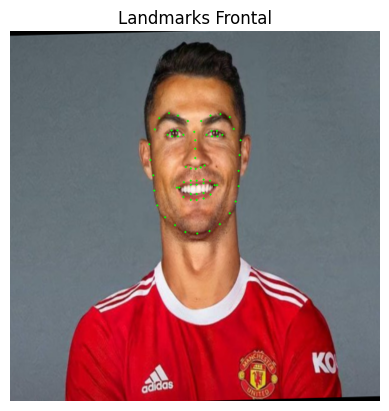

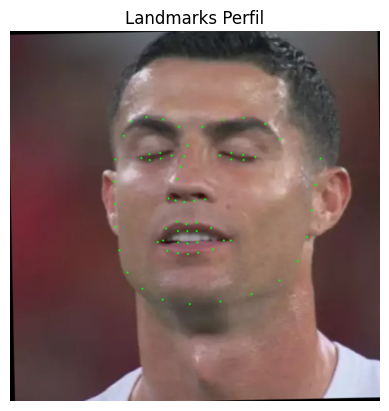

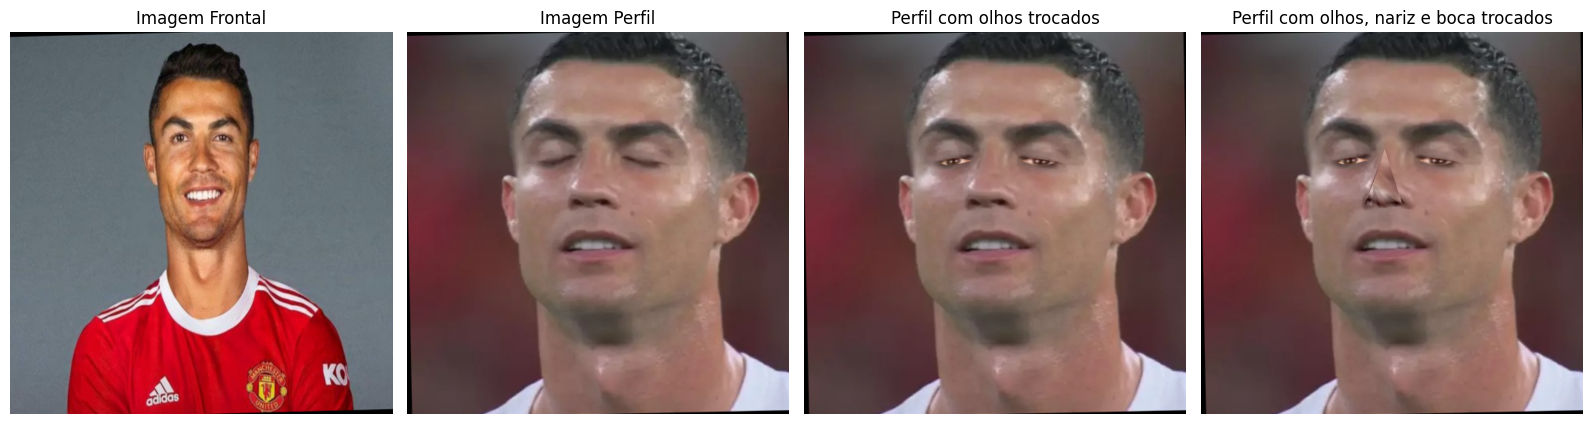

Imagens salvas com os nomes:
- perfil_olhos_trocados.jpg
- perfil_olhos_nariz.jpg


In [ ]:
caminho1 = input("Caminho ou URL da imagem FRONTAL: ")
caminho2 = input("Caminho ou URL da imagem PERFIL: ")

img1, lm1 = ler_imagem_e_landmarks(caminho1)
img2, lm2 = ler_imagem_e_landmarks(caminho2)

if len(lm1) != len(lm2):
    raise ValueError(f"Landmarks têm tamanhos diferentes: {len(lm1)} vs {len(lm2)}")

plot_landmarks(img1, lm1, "Landmarks Frontal")
plot_landmarks(img2, lm2, "Landmarks Perfil")

# Troca olhos
img_olhos = trocar_olhos_somente(img1, img2, lm1, lm2)

# Troca nariz
img_nariz = trocar_nariz(img1, img_olhos, lm1, lm2)

# # Troca boca
# img_boca = trocar_boca(img1, img_nariz, lm1, lm2)

# # Troca sobrancelhas
# img_final = trocar_sobrancelha(img1, img_boca, lm1, lm2)

plt.figure(figsize=(20,6))
plt.subplot(1,5,1)
plt.title("Imagem Frontal")
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,5,2)
plt.title("Imagem Perfil")
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,5,3)
plt.title("Perfil com olhos trocados")
plt.imshow(cv2.cvtColor(img_olhos, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,5,4)
plt.title("Perfil com olhos, nariz e boca trocados")
plt.imshow(cv2.cvtColor(img_nariz, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

cv2.imwrite("perfil_olhos_trocados.jpg", img_olhos)
cv2.imwrite("perfil_olhos_nariz.jpg", img_nariz)

print("Imagens salvas com os nomes:")
print("- perfil_olhos_trocados.jpg")
print("- perfil_olhos_nariz.jpg")

### Comparando Similaridade entre imagens

In [ ]:
# !pip install insightface
# !pip install onnxruntime  # se necessário
import insightface
from insightface.app import FaceAnalysis
import cv2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
# Inicializa o app
app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0)

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:05<00:00, 54497.59KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:
def get_embedding(image):
    faces = app.get(image)
    if len(faces) == 0:
        raise ValueError("Nenhum rosto detectado.")

    # Retorna o vetor de embedding da primeira face
    return faces[0].embedding

In [ ]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [ ]:
def show_faces(image):
  faces = app.get(image)

  for face in faces:
      box = face.bbox.astype(int)
      cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis("off")
  plt.show()

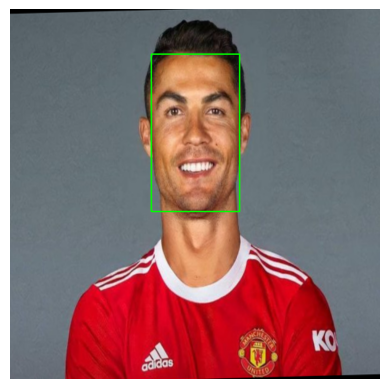

In [ ]:
show_faces(img1)

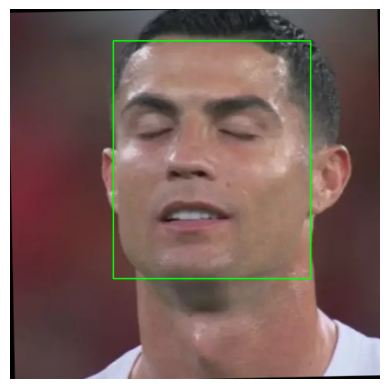

In [ ]:
show_faces(img2)

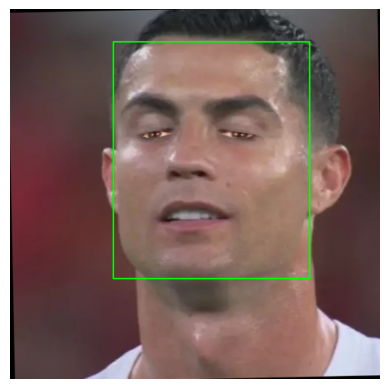

In [ ]:
show_faces(img_olhos)

In [ ]:
# Resultados entre a comparação das imagens originais
emb1 = get_embedding(img1)
emb2 = get_embedding(img2)

# Distância Euclidiana
similarity = cosine_similarity(emb1, emb2)

print(f"Distância entre embeddings Frontal X Perfil (Original): {similarity:.4f}")

# Limiares típicos para cosseno ficam perto de 0.5 a 0.7 para mesma pessoa
if similarity > 0.5:
    print("As imagens são da mesma pessoa!")
else:
    print("As imagens são de pessoas diferentes!")

Distância entre embeddings Frontal X Perfil (Original): 0.6414
As imagens são da mesma pessoa!


In [ ]:
# Resultados entre a comparação da imagem original com a alterada
emb1 = get_embedding(img1)
emb2 = get_embedding(img_olhos)

# Distância Euclidiana
similarity = cosine_similarity(emb1, emb2)

print(f"Distância entre embeddings Frontal X Perfil (Morphing): {similarity:.4f}")

# Limiares típicos para cosseno ficam perto de 0.5 a 0.7 para mesma pessoa
if similarity > 0.5:
    print("As imagens são da mesma pessoa!")
else:
    print("As imagens são de pessoas diferentes!")

Distância entre embeddings Frontal X Perfil (Morphing): 0.6624
As imagens são da mesma pessoa!
